In [1]:
# install required packages...
%matplotlib notebook
def install_packages():
    import sys
    !{sys.executable} -m pip install byol-pytorch
#install_packages()

from types import SimpleNamespace
from tqdm.auto import tqdm

import numpy as np
import torch
import torch.nn as nn
import torchsummary
import kornia

from byol_pytorch import BYOL


import notebook
import utils

import krate
import jnu as J

import tml # pytorch module libary

In [2]:
config = dict( 
    input_shape = (3,84,84),
    augment_shape = (3,40,40),
    latent_shape = (1024,),
    optim = "Adam",
    learning_rate = 0.0005,
    batch_size= 256,
    epochs = 100,
    device = "cuda:0"
)
config = SimpleNamespace(**config)

In [ ]:
dataset, loader = utils.dataset(config)

In [3]:
class CNet(nn.Sequential):
    def __init__(self, input_shape, output_shape):
        self.input_shape = input_shape
        self.output_shape = output_shape
        super().__init__(
            nn.Conv2d(3, 16, (5,5), 2), nn.LeakyReLU(),
            nn.Conv2d(16, 32, (5,5)), nn.LeakyReLU(),
            nn.Conv2d(32, 64, (5,5)), nn.LeakyReLU(),
            nn.Conv2d(64, 64, (5,5)), nn.LeakyReLU(),
            nn.AdaptiveAvgPool2d((4,4)),
            tml.Flatten((64, 4, 4)),
            nn.Linear(1024, output_shape[0])
        )
augment_fn = nn.Sequential(
    kornia.augmentation.RandomCrop(config.augment_shape[1:])
)
model_ = CNet(config.augment_shape, config.latent_shape).to(config.device)
model = BYOL(model_, image_size=config.input_shape[1], 
             projection_hidden_size=config.latent_shape[0], 
             augment_fn = augment_fn, use_momentum=False)
print(torchsummary.summary(model_,config.augment_shape))
optim = torch.optim.Adam(model.parameters(), lr=config.learning_rate)

#model(torch.zeros((256, *config.input_shape)).to(config.device))


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 18, 18]           1,216
         LeakyReLU-2           [-1, 16, 18, 18]               0
            Conv2d-3           [-1, 32, 14, 14]          12,832
         LeakyReLU-4           [-1, 32, 14, 14]               0
            Conv2d-5           [-1, 64, 10, 10]          51,264
         LeakyReLU-6           [-1, 64, 10, 10]               0
            Conv2d-7             [-1, 64, 6, 6]         102,464
         LeakyReLU-8             [-1, 64, 6, 6]               0
 AdaptiveAvgPool2d-9             [-1, 64, 4, 4]               0
          Flatten-10                 [-1, 1024]               0
           Linear-11                 [-1, 1024]       1,049,600
Total params: 1,217,376
Trainable params: 1,217,376
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.02
Forw

In [ ]:
info = J.HTML("Loss: -----")
display(info)
for e in tqdm(range(config.epochs)):
    for batch_x, in loader:
        optim.zero_grad()
        loss = model(batch_x)
        loss.backward()
        optim.step()
        #model.update_moving_average()
    info.value = f"Loss: {loss.item():0.4f}"
    

In [ ]:
torch.save(model.state_dict(), "./test-{0}-{1}.pt".format(config.augment_shape[1:], config.latent_shape))

In [5]:
dataset, _ = utils.test_dataset(config, shuffle=False)

In [4]:
sdict = torch.load("./test-{0}-{1}.pt".format(config.augment_shape[1:], config.latent_shape))
model.load_state_dict(sdict)


<All keys matched successfully>


tensor(0.9974) tensor(0.2817)


/home/ben/anaconda3/envs/PhD/lib/python3.7/site-packages/torch/nn/functional.py:3635: UserWarning: Default upsampling behavior when mode=bilinear is changed to align_corners=False since 0.4.0. Please specify align_corners=True if the old behavior is desired. See the documentation of nn.Upsample for details.
  "See the documentation of nn.Upsample for details.".format(mode)


interactive(children=(IntSlider(value=0, description='x', layout=Layout(width='99%'), max=1399), Output()), _d…

<IPython.core.display.Javascript object>


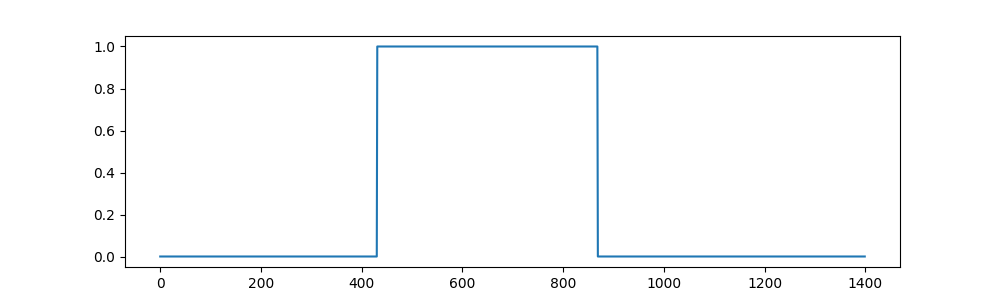

In [7]:

import torch.nn.functional as F
def loss_fn(x, y):
    return (x * y).sum(dim=-1)

def score(model, x):
    with torch.no_grad():
        z, _ = model.online_encoder(x)
        p = model.online_predictor(z)
        
        # compute distance matrix between z and p... :)
        z = F.normalize(z, dim=-1, p=2)
        p = F.normalize(p, dim=-1, p=2)
        y = (torch.mm(z, p.T) + 1) / 2 # [-1,1] -> [0,1] 
        i = torch.argmin(y, keepdim=True).item()
        
        # its symmetric :)
        i, j = i // y.shape[0], i % y.shape[0]
        return y[i, j].item(), y.cpu(), torch.cat([x[i], x[j]], dim=2).cpu()
    
import matplotlib.pyplot as plt
with torch.no_grad():
    model.eval()
    for x in dataset.datasets[4:5]:        
        x, y = x.tensors
        x, y = x[:1400], y[:1400]

    
        y = y.view(y.shape[0], -1).sum(-1) > 0
    
        scores = []
        x = x.to(config.device)
        stride = 5
        for z in tqdm(x): 
            z = z.unfold(1, config.augment_shape[1], stride).unfold(2, config.augment_shape[2], stride).transpose(2,0) # DDCHW
            z = z.reshape(-1, *z.shape[-3:]) # NCHW
            scores.append(score(model, z))
            
            
        scores, dm, images = list(zip(*scores))
        scores, dm, images = np.array(scores), torch.stack(dm), torch.stack(images)
  
        # show anomalous regions...
        sdm, sqrt = dm.sum(-1) / dm.shape[-1], int(np.sqrt(dm.shape[-1]))
        
        
        sdm = sdm.reshape(-1, sqrt, sqrt)
        dm = dm.unsqueeze(1)
        sdm = sdm.unsqueeze(1)
        
        
        print(sdm.max(), sdm.min())
        
        
        
        Resize = kornia.geometry.transform.Resize((dm.shape[2], dm.shape[3]), interpolation="nearest")
        images = kornia.geometry.transform.Resize((dm.shape[2], dm.shape[3] * 2))(images)
        
        
        
        _sdm, _x = Resize(sdm.repeat(1,3,1,1)).cpu(), Resize(x).cpu()
        J.images(torch.cat([_sdm, _x, (1 - _sdm) * _x, images], dim=3), scale=2)
        
        fig = plt.figure(figsize=(10,3))
        plt.plot(np.arange(y.shape[0]), y)
        
        
        
        """
        
        
        # visualise images
        dm = dm.unsqueeze(0).repeat(3,1,1)
        
        images = torch.cat([oimages, images, dm], dim=3)
        J.images(images, scale=3)
        
        scores = (scores - scores.min()) / (scores.max()-scores.min())
        plt.plot(np.arange(scores.shape[0]), scores)
        fig.canvas.draw()
        """
        
        break
  
        
        
        
    
        
        
    

        
        

    
    

In [ ]:
s = list(zip(scores))



In [ ]:






with torch.no_grad():
    for y in x:
        y = y.unsqueeze(0).repeat(256,1,1,1)
        score = model(y)
        print(score)